In [1]:
!pip install roboflow

from google.colab.patches import cv2_imshow
from roboflow import Roboflow

import albumentations
import csv
import cv2
import numpy as np
import pandas as pd
import random

rf = Roboflow(api_key="7iSKeb2wji6f2yncPgIQ")
project = rf.workspace().project("capstone_olm_logo_recognition")
dataset = project.version(1).download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics==8.0.196`, to intall it `pip install ultralytics==8.0.196`.


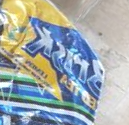

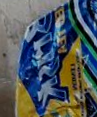

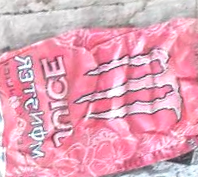

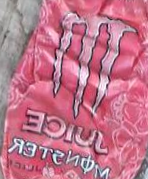

In [2]:
# Load the image

img_name = "112_Gq5m3KeQJUFNOCzkltNk9t92ucUgueWt9dVVTxUk_jpg.rf.5a227e08c43174a07e06e2841cbf8e1d"
image_path = '/content/Capstone_OLM_Logo_Recognition-1/train/images/'+img_name+'.jpg'
image = cv2.imread(image_path)

# Image dimensions
img_height, img_width, _ = image.shape

# Bounding boxes
'''
Source code: https://stackoverflow.com/questions/64096953/how-to-convert-yolo-format-bounding-box-coordinates-into-opencv-format
'''

def get_bb_params(img_name):
  '''
  img_name -> (str): string of the image name

  bb_output -> (list): list that is n long, where n is the number of identified BB
  '''
  bb_output = []
  with open('/content/Capstone_OLM_Logo_Recognition-1/train/labels/'+img_name+'.txt', 'r') as fd:
      reader = csv.reader(fd)
      for bounding_boxes in reader:
        # Seperate each item in the line
        bounding_boxes = bounding_boxes[0].split(" ")

        # Convert str to float
        bounding_boxes = [float(x) for x in bounding_boxes]
        # Draw bounding boxes
        class_id, center_x, center_y, bbox_width, bbox_height = bounding_boxes

        l = int((center_x - bbox_width / 2) * img_width)
        r = int((center_x + bbox_width / 2) * img_width)
        t = int((center_y - bbox_height / 2) * img_height)
        b = int((center_y + bbox_height / 2) * img_height)

        '''
        if l < 0:
            l = 0
        if r > img_width - 1:
            r = img_width - 1
        if t < 0:
            t = 0
        if b > img_height - 1:
            b = img_height - 1'''

        # Set x/y min/max
        x_min = l / img_width
        y_min = t / img_height
        x_max = r / img_width
        y_max = b / img_height

        bb_output.append([x_min, y_min, x_max, y_max, class_id])
  return bb_output

def apply_augmentation(transformation, bb_params):
      '''
      transformation -> albumentations.core.composition.Compose for transformations
      bb_params -> (list: output from get_bb_params)
      '''
      x_min, y_min, x_max, y_max, class_id = bb_params

      # Apply the transformation
      transformed = transform(image=image, bboxes=[[x_min, y_min, x_max, y_max, class_id]])

      # Extract the transformed image and bounding boxes
      transformed_image = transformed['image']
      transformed_bbox = transformed['bboxes'][0]


      # Convert transformed bounding box back to pixel coordinates for display
      l_pixels = int(transformed_bbox[0] * transformed_image.shape[1])
      t_pixels = int(transformed_bbox[1] * transformed_image.shape[0])
      r_pixels = int(transformed_bbox[2] * transformed_image.shape[1])
      b_pixels = int(transformed_bbox[3] * transformed_image.shape[0])

      cv2_imshow(transformed_image[t_pixels:b_pixels, l_pixels:r_pixels])


rotation_degrees = random.randint(-360,360)

# Define the augmentation pipeline
transform = albumentations.Compose([
            albumentations.HorizontalFlip(p=1),
            albumentations.RandomBrightnessContrast(p=1),
            albumentations.Rotate(rotation_degrees, p = 1),
        ], bbox_params=albumentations.BboxParams(format='albumentations'))

transform2 = albumentations.Compose([
            albumentations.VerticalFlip(p=1),
            albumentations.RandomBrightnessContrast(p=1),
            albumentations.Rotate(rotation_degrees, p = 1),
        ], bbox_params=albumentations.BboxParams(format='albumentations'))

bounding_box_parameters = get_bb_params(img_name)


for each_bb in bounding_box_parameters:

  apply_augmentation(transform, each_bb)
  apply_augmentation(transform2, each_bb)
# Print entire image with bounding boxes
#cv2_imshow(image)
#cv2.waitKey(0)